# Optimización automática de modelo v3

## Importar e instalar librerias

Instalar optimizadores

In [1]:
!pip install keras-tuner -q
!pip install scikeras -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


Importar librerias

In [7]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
import numpy as np
import pickle
import os
from keras import layers
from sklearn.utils import class_weight
print("✅ Entorno preparado.")

✅ Entorno preparado.


## Conectar Google Drive

In [3]:
# --- 1. Configuración del Entorno ---
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Configuración y Carga de Datos

Cargamos datos necesarios

In [4]:
# Cargamos los archivos que guardamos desde la notebook 09
ruta_datos = "/content/drive/MyDrive/Nimbus_AI/data/processed/modelo_multimodal/sets_finales/"

try:
    X_tabular_train_scaled = np.load(ruta_datos + "X_tabular_train_scaled.npy")
    X_tabular_test_scaled = np.load(ruta_datos + "X_tabular_test_scaled.npy")
    X_images_train = np.load(ruta_datos + "X_images_train.npy")
    X_images_test = np.load(ruta_datos + "X_images_test.npy")
    y_train = np.load(ruta_datos + "y_train.npy")
    y_test = np.load(ruta_datos + "y_test.npy")

    with open(os.path.join(ruta_datos, 'scaler.pkl'), 'rb') as f:
        scaler = pickle.load(f)

    print("✅ Todos los sets de datos y el scaler cargados exitosamente.")
    print("\n--- Verificación de Dimensiones ---")
    print(f"Forma de X_tabular_train_scaled: {X_tabular_train_scaled.shape}")
    print(f"Forma de X_images_train: {X_images_train.shape}")
    print(f"Forma de y_train: {y_train.shape}")

except FileNotFoundError:
    print(f"❌ ERROR: No se encontraron los archivos .npy en '{ruta_datos}'.")
    print("Asegúrate de haber ejecutado la última celda de la notebook 09 para guardar los datos.")

✅ Todos los sets de datos y el scaler cargados exitosamente.

--- Verificación de Dimensiones ---
Forma de X_tabular_train_scaled: (372, 22)
Forma de X_images_train: (372, 64, 64, 5)
Forma de y_train: (372,)


## La Función "Constructora" de Modelos

In [6]:
def build_model(hp):
    # --- Rama Tabular (MLP) ---
    input_tabular = keras.Input(shape=(X_tabular_train_scaled.shape[1],), name="input_numerico")

    # Hiperparámetro: Unidades en la primera capa densa. Probará con 16, 32, 48 o 64.
    units_1 = hp.Int('units_1', min_value=16, max_value=64, step=16)
    x = layers.Dense(units_1, activation="relu")(input_tabular)

    # Hiperparámetro: Unidades en la segunda capa densa. Probará con 8, 16 o 24.
    units_2 = hp.Int('units_2', min_value=8, max_value=32, step=8)
    x = layers.Dense(units_2, activation="relu")(x)

    rama_tabular_salida = layers.Dense(8, activation="relu")(x)

    # --- Rama de Imágenes (CNN) ---
    input_imagenes = keras.Input(shape=(64, 64, 5), name="input_visual")

    # Hiperparámetro: Número de filtros en la primera capa convolucional.
    filters_1 = hp.Choice('filters_1', values=[16, 32])
    y = layers.Conv2D(filters=filters_1, kernel_size=(3, 3), activation="relu")(input_imagenes)
    y = layers.MaxPooling2D(pool_size=(2, 2))(y)

    # Hiperparámetro: Número de filtros en la segunda capa convolucional.
    filters_2 = hp.Choice('filters_2', values=[32, 64])
    y = layers.Conv2D(filters=filters_2, kernel_size=(3, 3), activation="relu")(y)
    y = layers.MaxPooling2D(pool_size=(2, 2))(y)

    y = layers.Flatten()(y)
    rama_imagenes_salida = layers.Dense(32, activation="relu")(y)

    # --- Unión y Clasificación ---
    ramas_unidas = layers.concatenate([rama_tabular_salida, rama_imagenes_salida])

    # Hiperparámetro: Tasa de Dropout.
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)
    z = layers.Dropout(dropout_rate)(ramas_unidas)

    output_final = layers.Dense(1, activation="sigmoid", name="output_final")(z)

    modelo = keras.Model(inputs=[input_tabular, input_imagenes], outputs=[output_final])

    # Hiperparámetro: Tasa de Aprendizaje (Learning Rate).
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    modelo.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall(name='recall')] # Nos enfocamos en optimizar el Recall
    )
    return modelo

print("✅ Función 'build_model' creada. Lista para el optimizador.")

✅ Función 'build_model' creada. Lista para el optimizador.


## Configurar e Iniciar la Búsqueda

Este codigo tiene 3 etapas:
1.   Calcular los Pesos de Clase
2.   Configurar el Optimizador
3.   ¡Iniciar la Búsqueda!



In [8]:

#1)
# Sigue siendo importante para que el tuner evalúe los modelos correctamente
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

#2)
# Usaremos Hyperband, un algoritmo eficiente para la búsqueda
tuner = kt.Hyperband(
    build_model, # La función que creamos en la celda anterior
    objective=kt.Objective("val_recall", direction="max"), # Le decimos que queremos maximizar el Recall en los datos de validación
    max_epochs=30,
    factor=3,
    # Directorio para guardar los resultados de cada prueba
    directory='/content/drive/MyDrive/Nimbus_AI/models/tuner_results',
    project_name='nimbus_ai_v3.1_optimization'
)

# Creamos un callback para detener el entrenamiento de cada prueba si no mejora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#3)
print("\nIniciando la búsqueda de los mejores hiperparámetros... Esto tomará un tiempo.")

tuner.search(
    [X_tabular_train_scaled, X_images_train],
    y_train,
    epochs=50, # Un número alto, EarlyStopping decidirá cuándo parar
    validation_data=([X_tabular_test_scaled, X_images_test], y_test),
    callbacks=[stop_early],
    class_weight=class_weights_dict
)

print("\n✅ Búsqueda de hiperparámetros finalizada.")

Trial 90 Complete [00h 00m 13s]
val_recall: 0.699999988079071

Best val_recall So Far: 1.0
Total elapsed time: 00h 16m 49s

✅ Búsqueda de hiperparámetros finalizada.


## Visualizacion de la mejor arquitectura

In [9]:
# --- Obtener los mejores hiperparámetros ---
# Le pedimos al 'tuner' que nos muestre el mejor resultado
mejores_hiperparametros = tuner.get_best_hyperparameters(num_trials=1)[0]

print("--- Mejor Configuración Encontrada ---")
print(f"Neuronas Capa 1 (Tabular): {mejores_hiperparametros.get('units_1')}")
print(f"Neuronas Capa 2 (Tabular): {mejores_hiperparametros.get('units_2')}")
print(f"Filtros Capa 1 (Imágenes): {mejores_hiperparametros.get('filters_1')}")
print(f"Filtros Capa 2 (Imágenes): {mejores_hiperparametros.get('filters_2')}")
print(f"Tasa de Dropout: {mejores_hiperparametros.get('dropout_rate'):.2f}")
print(f"Tasa de Aprendizaje (LR): {mejores_hiperparametros.get('learning_rate')}")

--- Mejor Configuración Encontrada ---
Neuronas Capa 1 (Tabular): 32
Neuronas Capa 2 (Tabular): 16
Filtros Capa 1 (Imágenes): 16
Filtros Capa 2 (Imágenes): 32
Tasa de Dropout: 0.30
Tasa de Aprendizaje (LR): 0.0001


## Entrenar y evaluar el modelo ganador

✅ Mejor modelo obtenido del tuner.

--- Evaluación Definitiva del Modelo Optimizado (V3.1) ---
Pérdida (Loss): 0.7182
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step

--- Reporte de Clasificación Final ---
                precision    recall  f1-score   support

No Granizo (0)       1.00      0.25      0.40        84
   Granizo (1)       0.14      1.00      0.24        10

      accuracy                           0.33        94
     macro avg       0.57      0.62      0.32        94
  weighted avg       0.91      0.33      0.38        94


--- Matriz de Confusión Final ---


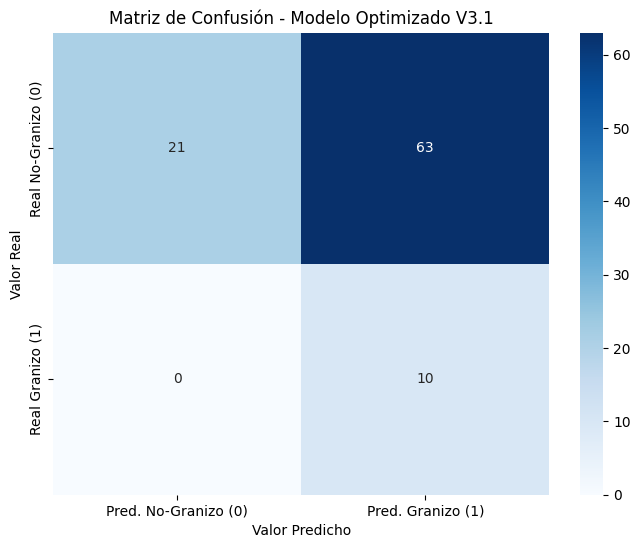


✅ Modelo final optimizado guardado en: '/content/drive/MyDrive/Nimbus_AI/models/multimodal_v3.1_optimizado.keras'


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Obtener el mejor modelo encontrado por el tuner ---
best_model = tuner.get_best_models(num_models=1)[0]
print("✅ Mejor modelo obtenido del tuner.")

# --- 2. Evaluación Definitiva del Modelo Optimizado (V3.1) ---
print("\n--- Evaluación Definitiva del Modelo Optimizado (V3.1) ---")

# Hacemos la evaluación y guardamos los resultados en un diccionario
results_dict = dict(zip(best_model.metrics_names, best_model.evaluate([X_tabular_test_scaled, X_images_test], y_test, verbose=0)))

# Verificamos si cada métrica existe antes de intentar imprimirla.
if 'loss' in results_dict:
    print(f"Pérdida (Loss): {results_dict['loss']:.4f}")
if 'recall' in results_dict:
    print(f"Sensibilidad (Recall): {results_dict['recall']:.4f}")
if 'precision' in results_dict:
    print(f"Precisión (Precision): {results_dict['precision']:.4f}")
if 'accuracy' in results_dict:
    print(f"Exactitud (Accuracy): {results_dict['accuracy']:.4f}")
# =================================

# --- 3. Reporte de Clasificación y Matriz de Confusión ---
y_pred_probs = best_model.predict([X_tabular_test_scaled, X_images_test])
y_pred = (y_pred_probs > 0.5).astype(int)

print("\n--- Reporte de Clasificación Final ---")
print(classification_report(y_test, y_pred, target_names=['No Granizo (0)', 'Granizo (1)'], zero_division=0))

print("\n--- Matriz de Confusión Final ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. No-Granizo (0)', 'Pred. Granizo (1)'],
            yticklabels=['Real No-Granizo (0)', 'Real Granizo (1)'])
plt.title('Matriz de Confusión - Modelo Optimizado V3.1')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# --- 4. Guardar el Modelo Final ---
ruta_modelo_final = "/content/drive/MyDrive/Nimbus_AI/models/multimodal_v3.1_optimizado.keras"
best_model.save(ruta_modelo_final)
print(f"\n✅ Modelo final optimizado guardado en: '{ruta_modelo_final}'")